# 1. Datos del Alumno y Título del Proyecto

**Nombre:** Joel
**Apellidos:** Roca Moro  
**Título del Proyecto:** Ajuste Fino de DistilRoBERTa para Análisis de Sentimiento en Tweets  
**Asignatura:** Deep Learning para el Procesamiento del Lenguaje Natural  
**Fecha:**  22 de noviembre de 2025  

Este proyecto consiste en el fine-tuning de un modelo de lenguaje preentrenado para una tarea de clasificación de texto en NLP.

## 2. Introducción

### Descripción de la tarea de NLP
La tarea seleccionada es el análisis de sentimiento en textos cortos, específicamente tweets. Esta es una tarea de clasificación de texto donde se predice si un tweet expresa un sentimiento negativo (0), neutral (1) o positivo (2). 

### Justificación de la elección del LM y la técnica de ajuste fino
Se elige **DistilRoBERTa-base** como modelo base, una variante destilada de RoBERTa (basada en BERT), preentrenada en grandes corpus de texto en inglés. Esta elección se basa en su eficiencia: es más ligero que BERT completo, lo que reduce el tiempo de entrenamiento y el consumo de recursos en entornos como Google Colab, sin sacrificar mucho rendimiento en tareas downstream como clasificación.

La técnica de ajuste fino es el **fine-tuning supervisado** usando la clase `Trainer` de Hugging Face Transformers. Esto nos permite adaptar el modelo preentrenado a nuestro tarea en específico, reemplazando la cabeza de clasificación y entrenando con datos etiquetados.

### Comprobación previa
Comprobamos que la GPU está activa.

In [40]:
!pip install torch
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected.")
    print("If you are using Google Colab, please go to 'Runtime' > 'Change runtime type' and select 'GPU' as the hardware accelerator.")

GPU detected: Tesla T4


## Installation of Libraries
Let us start installing required libraries for fine tuning a model. You may need to restart the environment (Runtime → Restart Runtime)

* transformers: provides pretrained models like BERT, RoBERTa, etc., for NLP tasks
* datasets: easy access to thousands of NLP datasets with built-in processing tools
* evaluate: provides standard evaluation metrics (e.g., accuracy, F1) for model evaluation
* accelerate: utility for training models efficiently on CPU, GPU, or multi-GPU setups

In [41]:
!pip install -q transformers datasets accelerate evaluate


## 3. Dataset

### Descripción y fuente
El dataset utilizado es **tweet_eval** en su subconjunto de "sentiment", disponible en la librería `datasets` de Hugging Face (https://huggingface.co/datasets/tweet_eval). Contiene tweets en inglés etiquetados con sentimientos: negativo (0), neutral (1) y positivo (2). Es ideal para esta tarea ya que representa texto real de redes sociales, con distintos tipos de ruido como abreviaturas y emojis.

### Estadísticas
- Train: 45,615 ejemplos.
- Validation: 1,227 ejemplos.
- Test: 12,284 ejemplos.
- Clases: 3 (negativo, neutral, positivo).
- Longitud media de tweets: ~10-30 tokens.


In [42]:
from datasets import load_dataset

TASK = "sentiment" # to be modified if running other tasks


dataset = load_dataset("tweet_eval", TASK)

# Print dataset example
print(dataset['train'][0])
print(dataset['train'][1])



{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}
{'text': '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"', 'label': 1}


### Preprocesamiento de datos

En esta sección, preparamos el conjunto de datos para su uso en un modelo de lenguaje. A continuación se detallan los pasos que seguimos:

- **Cargar el Tokenizador**: Utilizamos el tokenizador de `distilroberta-base` de la biblioteca Hugging Face, que convierte el texto en un formato adecuado para el modelo.

- **Función de Tokenización**: Creamos una función que tokeniza el texto de cada ejemplo. Esta función realiza varias tareas:
  - **Truncamiento**: Corta las secuencias que exceden la longitud máxima permitida.
  - **Relleno (Padding)**: Asegura que todas las secuencias tengan la misma longitud añadiendo tokens de relleno cuando es necesario.

- **Aplicación de la Tokenización**: Aplicamos la función de tokenización a todo el conjunto de datos utilizando el método `map()`. Esto procesa los textos en lotes, lo que acelera el proceso.

- **Preparación para PyTorch**: Configuramos el conjunto de datos para que sea compatible con PyTorch, seleccionando las columnas necesarias como `input_ids`, `attention_mask` y `label`. Esto garantiza que el modelo pueda procesar correctamente las entradas durante el entrenamiento.

In [ ]:
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)


# Apply tokenization
encoded = dataset.map(tokenize_function, batched=True)


# Prepare for PyTorch
encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Print dataset example after tokenizing. Data contain: label, text, input_ids, token_type_ids, and attention_mask
print(encoded["train"][0])
print(encoded["train"][1])

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

{'label': tensor(2), 'input_ids': tensor([    0,   113,  1864,   565,   787, 12105,    96,     5,  1461,  2479,
            9,     5,   262,   212,  1040,     6,  8022,   687, 26110,   179,
         5601,     5,  9846,     9, 42210,     4,   849, 21136, 44728,  1208,
        31157,   687,   574,   658,   179,   113,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,  

## 4. Implementación

En esta sección describimos la configuración del modelo, los hiperparámetros seleccionados y el proceso de ajuste fino utilizando la librería Transformers. El objetivo es adaptar un Modelo de Lenguaje (LM) preentrenado a una tarea específica del dataset **TweetEval**.

### Carga del Modelo de Lenguaje Preentrenado

Para este proyecto se utiliza **DistilRoBERTa-base**, una versión ligera y eficiente de RoBERTa obtenida mediante *knowledge distillation*. Este modelo mantiene un rendimiento competitivo con un coste computacional reducido, siendo ideal para entrenamiento en GPU limitadas.

El dataset TweetEval contiene diferentes tareas, cada una con su propio conjunto de etiquetas y por ello el número de clases se obtiene dinámicamente a partir del conjunto de entrenamiento.

In [45]:
from transformers import AutoModelForSequenceClassification
# Label info depends on task
label_names = dataset["train"].features["label"].names
num_labels = len(label_names)
model_name = "distilroberta-base"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Métricas de Evaluación

Durante el entrenamiento se emplea la métrica **accuracy**, cargada con la librería `evaluate`.  
El método `compute_metrics` recibe las predicciones del modelo (logits) y calcula la exactitud comparándolas con las etiquetas reales.

Este método será llamado automáticamente por el objeto `Trainer` al final de cada epoch.


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

# Load the accuracy metric from the 🤗 Evaluate library
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred): # Will be passed to a Trainer object
    logits, labels = eval_pred  # Unpack predictions (logits) and true labels from the evaluation output
    # Convert logits to predicted class indices by selecting the index with the highest value for each example
    predictions = np.argmax(logits, axis=-1)
    # Compute and return the accuracy metric by comparing predictions with true labels
    return metric.compute(predictions=predictions, references=labels)


### Hiperparámetros de Entrenamiento

Los hiperparámetros se definen con `TrainingArguments`, incluyendo tasas de aprendizaje, estrategias de evaluación y guardado, tamaño de batch y número de épocas.

La configuración final es la siguiente:

- **learning_rate = 2e-5**: valor estándar para ajustar modelos basados en BERT/RoBERTa.
- **batch_size = 16**: equilibra rendimiento y consumo de memoria.
- **num_train_epochs = 3**: TweetEval es un dataset relativamente pequeño, más épocas tienden a sobreajustar.
- **weight_decay = 0.01**: regularización ligera para mejorar generalización.
- **eval_strategy = "epoch"**: evaluación automática al final de cada epoch.
- **load_best_model_at_end = True**: asegura que se recupere el mejor checkpoint al finalizar.


In [ ]:

# Define training arguments including output directory and evaluation strategy
training_args = TrainingArguments(
    output_dir="results",  # Directory where model checkpoints and outputs will be saved
    eval_strategy="epoch",       # Perform evaluation at the end of each training epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    load_best_model_at_end=True,
)

### Entrenamiento y evaluación

El objeto `Trainer` recibe:
- el modelo,
- los argumentos de entrenamiento,
- los conjuntos `train` y `validation`,
- la función de métricas,
- y el tokenizer.

Finalmente se llama a:
- `trainer.train()` para realizar el ajuste fino,
- `trainer.evaluate()` para medir el rendimiento final.

In [ ]:

trainer = Trainer(
    model=model,  # The model to be trained 
    args=training_args,  # Training configuration and hyperparameters (TrainingArguments object)
    train_dataset=encoded["train"],  # The dataset used for training the model
    eval_dataset=encoded["validation"],  # The dataset used for evaluation during training
    compute_metrics=compute_metrics,  # Function to calculate metrics like accuracy or F1 during evaluation
    tokenizer=tokenizer,  # Tokenizer used for preprocessing text data
)

trainer.train()  # Start the training process using the specified model, datasets, and arguments
trainer.evaluate() # Evaluate the trained model on the evaluation dataset and compute metrics

/tmp/ipython-input-292541637.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.613900,0.622909,0.725500
2,0.526300,0.627849,0.731500
3,0.424900,0.667797,0.730000


{'eval_loss': 0.6229087114334106,
 'eval_accuracy': 0.7255,
 'eval_runtime': 6.4596,
 'eval_samples_per_second': 309.619,
 'eval_steps_per_second': 19.351,
 'epoch': 3.0}

## 5. Resultados y Discusión

Tras el entrenamiento, se evalúa el modelo sobre el conjunto de test mediante
`trainer.predict()`, obteniendo tanto los *logits* como las etiquetas verdaderas.

Para analizar más detalladamente los errores del modelo, se construye una **matriz de
confusión** mediante `sklearn.metrics`.  
Esta matriz permite observar en qué clases se producen mayores confusiones y nos permite interpretar las limitaciones del modelo.
El uso de `ConfusionMatrixDisplay` facilita visualizar:

- patrones de confusión entre clases
- clases que se predicen correctamente con mayor frecuencia
- posibles desbalances o problemas de representación en los datos

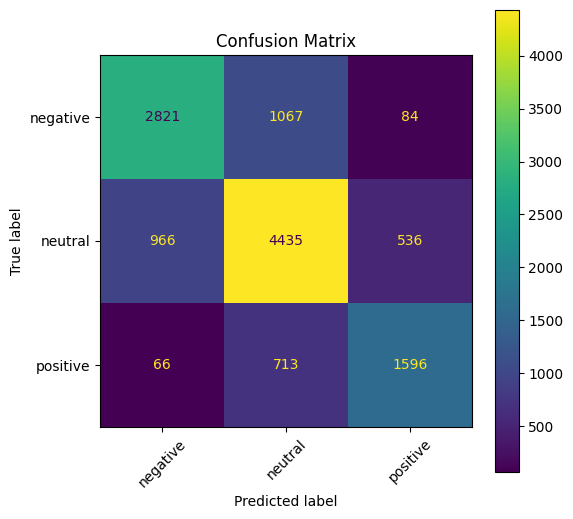

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = trainer.predict(encoded["test"])
logits = predictions.predictions
pred_labels = np.argmax(logits, axis=-1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

En este caso, el modelo acierta sobre todo en la clase neutral, mientras que confunde bastantes ejemplos de negative y positive con neutral. Esto nos indica que el modelo se desempeña bien en textos claros, pero tiene dificultad con tweets ambiguos o poco emocionales.

### Guardamos el modelo y el tokenizer

In [50]:
save_path = "./finetuned_tweeteval_" + TASK
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


print(f"Model saved to: {save_path}")

Model saved to: ./finetuned_tweeteval_sentiment


### Predicción con el modelo ajustado

Para evaluar el modelo en ejemplos nuevos, primero tokenizamos los tweets utilizando la misma configuración que en el entrenamiento.  
Después, ponemos el modelo en modo evaluación (`model.eval()`) y obtenemos las predicciones mediante `argmax` sobre los *logits*.  
Finalmente aplicamos `softmax` para convertir los logits en probabilidades interpretables.


In [57]:
import torch.nn.functional as F  # To use softmax for probabilities

# Example new tweets to classify
new_tweets = [
"I love how people think they know everything on twitter lol",
"This is the worst thing I've read today",
"I'm not sure how to feel about this",
"Amazing! Couldn't be happier",
"Total disaster... unbelievable",
"I have a lot of opinions on this matter",
"The news today doesn't really excite me, it's just whatever"
]


# Tokenize using same settings as training
inputs = tokenizer(new_tweets, padding="max_length", truncation=True, return_tensors="pt")


# Move model to device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()


# Move inputs to device
inputs = {key: value.to(device) for key, value in inputs.items()}


# Predict
torch.manual_seed(0)
with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

  # Use softmax to convert logits to probabilities
  probs = F.softmax(logits, dim=-1)  # Apply softmax to logits to get probabilities

# Map predictions to human-readable class labels
class_labels = label_names


# Print results
for tweet, pred, prob in zip(new_tweets, predictions, probs):
  prob_class = prob[pred].item()
  print(f"{tweet} → {class_labels[pred]} ({prob_class:.4f})")

I love how people think they know everything on twitter lol → positive (0.8503)
This is the worst thing I've read today → negative (0.9583)
I'm not sure how to feel about this → negative (0.4976)
Amazing! Couldn't be happier → positive (0.9858)
Total disaster... unbelievable → negative (0.7685)
I have a lot of opinions on this matter → neutral (0.8686)
The news today doesn't really excite me, it's just whatever → negative (0.6436)


Estas predicciones muestran que el modelo es capaz de identificar correctamente textos claramente positivos o negativos, y también distingue casos más ambiguos como el tweet clasificado como *neutral*. No obstante, tiende a clasificar como negativo cualquier expresión ambigua o con negaciones leves, lo que nos indica que una posible mejora sería entrenarlo con más ejemplos neutrales sútiles.


## 6. Conclusiones

En este proyecto se ha realizado el ajuste fino de un modelo de lenguaje preentrenado (DistilRoBERTa) para una de las tareas del dataset TweetEval.  
El proceso ha incluido la preparación del dataset, la tokenización, la definición de los hiperparámetros de entrenamiento, la utilización del método `Trainer` y la evaluación final mediante métricas y matriz de confusión.

Los resultados muestran que el modelo alcanza un rendimiento sólido, especialmente en la clasificación de tweets con polaridad clara (muy positivos o muy negativos). La matriz de confusión evidencia que la clase *neutral* es la más fácil de identificar, mientras que las clases *positive* y *negative* presentan mayor solapamiento, algo típico en textos con carácter tan breve e informal como el de Twitter.

Las predicciones sobre ejemplos nuevos también confirman que el modelo generaliza bien, ofreciendo probabilidades coherentes con lo que se esperaría y mostrando confianza alta cuando el tono emocional del tweet es evidente.

En resumen, el ajuste fino ha sido exitoso y ha demostrado la capacidad de modelos preentrenados para adaptarse a tareas específicas de NLP con un número reducido de ejemplos y un proceso de entrenamiento eficiente.
